## Volatility Target Strategy

In [161]:
# import os
# os.chdir('C:\\Users\\USER\\Desktop\\vol_tgt')

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

os.chdir('C:\\Users\\USER\\Desktop\\vol_tgt')

# df_hc1 = pd.read_excel('bb_hscei.xlsx', sheet_name = 'HC1')
df_hscei = pd.read_excel('bb_hscei.xlsx', sheet_name = 'HC1')

In [163]:
df_hscei_idx = df_hscei[['DATE', 'HSCEI Index']]
df_hscei_idx.rename(columns = {'HSCEI Index': 'HSCEI'}, inplace = True)
df_hscei_idx = df_hscei_idx[df_hscei_idx['DATE'].between('2013-12-01', '2023-12-31')]
# df_hscei_idx = df_hscei_idx[df_hscei_idx['DATE'] >= '2021-01-01']

C:\Users\USER\AppData\Local\Temp\ipykernel_16820\4203832560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hscei_idx.rename(columns = {'HSCEI Index': 'HSCEI'}, inplace = True)


In [164]:
df_hscei_idx = df_hscei_idx.set_index('DATE')

### Simple Volatility & Exponentially-Weighted-Moving-Average Volatility

In [165]:
rolling_size = 10

df_hscei_idx['HSCEI_ret'] = np.log(df_hscei_idx['HSCEI'] / df_hscei_idx['HSCEI'].shift(1))
df_hscei_idx['realized_vol'] = df_hscei_idx.HSCEI_ret.rolling(rolling_size).std(ddof = 0) * np.sqrt(252)
df_hscei_idx['realized_vol_ewm'] = df_hscei_idx.HSCEI_ret.ewm(span = 10, min_periods = 10).std() * np.sqrt(252)

df_hscei_idx['realized_vol_2'] = df_hscei_idx['realized_vol'].shift(1)
df_hscei_idx['realized_vol_ewm_2'] = df_hscei_idx['realized_vol_ewm'].shift(1)
# df_hscei_idx.head(30)

In [166]:
df_hscei_idx = df_hscei_idx.reset_index()
df_hscei_idx = df_hscei_idx.sort_values(by='DATE', ascending=True)
df_hscei_idx['YEAR_WEEK'] = df_hscei_idx.DATE.dt.strftime('%Y-%U')
df_hscei_idx['WEEK_LAST'] = df_hscei_idx.DATE.isin(list(df_hscei_idx.groupby('YEAR_WEEK').DATE.max()))

date_list_rebal = list(df_hscei_idx[df_hscei_idx.WEEK_LAST].DATE)

def get_back_data(date):
    idx = df_hscei_idx[df_hscei_idx.DATE==date].index.values[0] # -1
    data = df_hscei_idx.iloc[idx]
    data = data if idx >= 0 else data.drop(data.index)
    return data

# get_back_data = lambda date: df_strategy.iloc[().values[0]-1]
back_data_list = [get_back_data(date) for date in date_list_rebal]
back_data = pd.concat(back_data_list, axis=1).T.dropna(subset=['DATE'])
back_data = back_data[['DATE', 'realized_vol_2']]
back_data2 = pd.concat(back_data_list, axis=1).T.dropna(subset=['DATE'])
back_data2 = back_data2[['DATE', 'realized_vol_ewm_2']]

df_hscei_idx = pd.merge(df_hscei_idx, back_data, how='left', on='DATE', suffixes=['', '_apply'])
df_hscei_idx = pd.merge(df_hscei_idx, back_data2, how='left', on='DATE', suffixes=['', '_apply'])
df_hscei_idx.realized_vol_2_apply = df_hscei_idx.realized_vol_2_apply.fillna(method='ffill')
df_hscei_idx.realized_vol_ewm_2_apply = df_hscei_idx.realized_vol_ewm_2_apply.fillna(method='ffill')

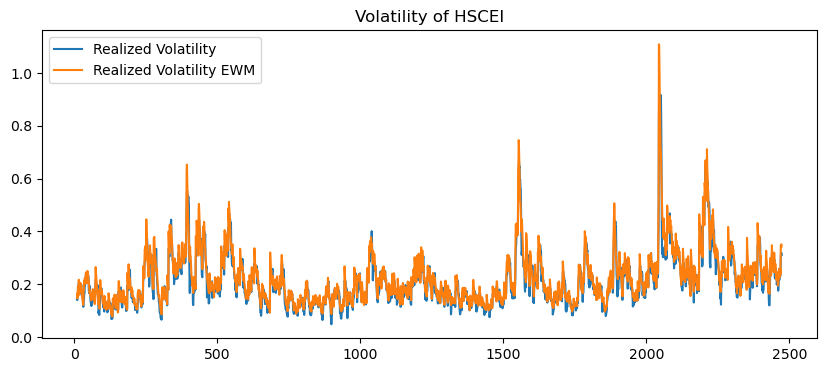

0.21038977885003812
0.22319383553609065


In [167]:
plt.figure(figsize = (10, 4))
plt.plot(df_hscei_idx['realized_vol'], label = 'Realized Volatility')
plt.plot(df_hscei_idx['realized_vol_ewm'], label = 'Realized Volatility EWM')
plt.title('Volatility of HSCEI')
plt.legend()
plt.show()

print(df_hscei_idx['realized_vol'].mean())
print(df_hscei_idx['realized_vol_ewm'].mean())

In [168]:
df_hscei_idx

,DATE,HSCEI,HSCEI_ret,realized_vol,realized_vol_ewm,realized_vol_2,realized_vol_ewm_2,YEAR_WEEK,WEEK_LAST,realized_vol_2_apply,realized_vol_ewm_2_apply
0,2013-12-02,11536,NaN,NaN,NaN,NaN,NaN,2013-48,False,NaN,NaN
1,2013-12-03,11432,-0.009056,NaN,NaN,NaN,NaN,2013-48,False,NaN,NaN
2,2013-12-04,11357,-0.006582,NaN,NaN,NaN,NaN,2013-48,False,NaN,NaN
3,2013-12-05,11393,0.003165,NaN,NaN,NaN,NaN,2013-48,False,NaN,NaN
4,2013-12-06,11373,-0.001757,NaN,NaN,NaN,NaN,2013-48,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2469,2023-11-14,5974,-0.006341,0.232865,0.236055,0.232259,0.256828,2023-46,False,0.218604,0.225250
2470,2023-11-15,6225,0.041157,0.298074,0.346015,0.232865,0.236055,2023-46,False,0.218604,0.225250
2471,2023-11-16,6123,-0.016521,0.312704,0.346844,0.298074,0.346015,2023-46,False,0.218604,0.225250
2472,2023-11-17,5990,-0.021961,0.319017,0.351004,0.312704,0.346844,2023-46,True,0.312704,0.346844


In [169]:
df_hscei_idx = df_hscei_idx.set_index('DATE')

In [170]:
df_hscei_idx = df_hscei_idx.fillna(0)

tgt_vol = 0.2
lev_factor_min = 0.5
lev_factor_max = 1.5

df_hscei_idx['lev_factor'] = 0
df_hscei_idx['ewm_lev_factor'] = 0


for i in range(len(df_hscei_idx)):
    if tgt_vol / df_hscei_idx['realized_vol_2_apply'][i] > lev_factor_max:
        df_hscei_idx['lev_factor'][i] = lev_factor_max
        
        if tgt_vol / df_hscei_idx['realized_vol_2_apply'][i] == np.inf:
            df_hscei_idx['lev_factor'][i] = 0
            
    elif tgt_vol / df_hscei_idx['realized_vol_2_apply'][i] < lev_factor_min:
        df_hscei_idx['lev_factor'][i] = lev_factor_min
        
        if tgt_vol / df_hscei_idx['realized_vol_2_apply'][i] == np.inf:
            df_hscei_idx['lev_factor'][i] = 0
        
    else:
        df_hscei_idx['lev_factor'][i] = tgt_vol / df_hscei_idx['realized_vol_2_apply'][i]
        
        
for i in range(len(df_hscei_idx)):
    if tgt_vol / df_hscei_idx['realized_vol_ewm_2_apply'][i] > lev_factor_max:
        df_hscei_idx['ewm_lev_factor'][i] = lev_factor_max
        
        if tgt_vol / df_hscei_idx['realized_vol_ewm_2_apply'][i] == np.inf:
            df_hscei_idx['ewm_lev_factor'][i] = 0
            
    elif tgt_vol / df_hscei_idx['realized_vol_ewm_2_apply'][i] < lev_factor_min:
        df_hscei_idx['ewm_lev_factor'][i] = lev_factor_min
        
        if tgt_vol / df_hscei_idx['realized_vol_ewm_2_apply'][i] == np.inf:
            df_hscei_idx['ewm_lev_factor'][i] = 0
        
    else:
        df_hscei_idx['ewm_lev_factor'][i] = tgt_vol / df_hscei_idx['realized_vol_ewm_2_apply'][i]

C:\Users\USER\AppData\Local\Temp\ipykernel_16820\310105870.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  if tgt_vol / df_hscei_idx['realized_vol_2_apply'][i] > lev_factor_max:
C:\Users\USER\AppData\Local\Temp\ipykernel_16820\310105870.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hscei_idx['lev_factor'][i] = lev_factor_max
C:\Users\USER\AppData\Local\Temp\ipykernel_16820\310105870.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  if tgt_vol / df_hscei_idx['realized_vol_2_apply'][i] == np.inf:
C:\Users\USER\AppData\Local\Temp\ipykernel_16820\310105870.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  if tgt_vol / df_hscei_idx['realized_vol_2_apply'][i] > lev_factor_max:
C:\Users\USER\AppData\Local\Temp\ipykernel_16820\310105870.py:29

In [171]:
df_hscei_idx.head(50)

,HSCEI,HSCEI_ret,realized_vol,realized_vol_ewm,realized_vol_2,realized_vol_ewm_2,YEAR_WEEK,WEEK_LAST,realized_vol_2_apply,realized_vol_ewm_2_apply,lev_factor,ewm_lev_factor
DATE,,,,,,,,,,,,
2013-12-02,11536,0.000000,0.000000,0.000000,0.000000,0.000000,2013-48,False,0.000000,0.000000,0.000000,0.000000
2013-12-03,11432,-0.009056,0.000000,0.000000,0.000000,0.000000,2013-48,False,0.000000,0.000000,0.000000,0.000000
2013-12-04,11357,-0.006582,0.000000,0.000000,0.000000,0.000000,2013-48,False,0.000000,0.000000,0.000000,0.000000
2013-12-05,11393,0.003165,0.000000,0.000000,0.000000,0.000000,2013-48,False,0.000000,0.000000,0.000000,0.000000
2013-12-06,11373,-0.001757,0.000000,0.000000,0.000000,0.000000,2013-48,True,0.000000,0.000000,0.000000,0.000000
2013-12-09,11409,0.003160,0.000000,0.000000,0.000000,0.000000,2013-49,False,0.000000,0.000000,0.000000,0.000000
2013-12-10,11376,-0.002897,0.000000,0.000000,0.000000,0.000000,2013-49,False,0.000000,0.000000,0.000000,0.000000
2013-12-11,11095,-0.025011,0.000000,0.000000,0.000000,0.000000,2013-49,False,0.000000,0.000000,0.000000,0.000000
2013-12-12,10950,-0.013155,0.000000,0.000000,0.000000,0.000000,2013-49,False,0.000000,0.000000,0.000000,0.000000


In [172]:
df_hscei_idx['HSCEI_lev_factor'] = df_hscei_idx['lev_factor'].shift(2) * df_hscei_idx['HSCEI_ret']
df_hscei_idx['HSCEI_lev_factor_ewm'] = df_hscei_idx['ewm_lev_factor'].shift(2) * df_hscei_idx['HSCEI_ret']
# df_hscei_idx['HSCEI_lev_factor_idx'] = df_hscei_idx['HSCEI'].shift(1) * df_hscei_idx['HSCEI_lev_factor']
# df_hscei_idx['HSCEI_lev_factor_idx_ret'] = np.log(df_hscei_idx['HSCEI_lev_factor_idx'] / df_hscei_idx['HSCEI_lev_factor_idx'].shift(1))
# df_hscei_idx['HSCEI_lev_factor_idx_ret'].replace(np.inf, 0, inplace = True)
# df_hscei_idx = df_hscei_idx.fillna(0)

df_hscei_idx['HSCEI_ret_acc'] = df_hscei_idx['HSCEI_ret'].cumsum()
df_hscei_idx['HSCEI_lev_factor_ret_acc'] = df_hscei_idx['HSCEI_lev_factor'].cumsum()
df_hscei_idx['HSCEI_lev_factor_ret_ewm_acc'] = df_hscei_idx['HSCEI_lev_factor_ewm'].cumsum()
df_hscei_idx.tail(50)

,HSCEI,HSCEI_ret,realized_vol,realized_vol_ewm,realized_vol_2,realized_vol_ewm_2,YEAR_WEEK,WEEK_LAST,realized_vol_2_apply,realized_vol_ewm_2_apply,lev_factor,ewm_lev_factor,HSCEI_lev_factor,HSCEI_lev_factor_ewm,HSCEI_ret_acc,HSCEI_lev_factor_ret_acc,HSCEI_lev_factor_ret_ewm_acc
DATE,,,,,,,,,,,,,,,,,
2023-09-12,6288,-0.002700,0.232100,0.214495,0.250969,0.236789,2023-37,False,0.267999,0.288509,0.746271,0.693220,-0.002015,-0.001872,-0.606830,-0.407582,-0.206994
2023-09-13,6255,-0.005262,0.231496,0.195750,0.232100,0.214495,2023-37,False,0.267999,0.288509,0.746271,0.693220,-0.003927,-0.003648,-0.612091,-0.411509,-0.210642
2023-09-14,6282,0.004307,0.224805,0.181635,0.231496,0.195750,2023-37,False,0.267999,0.288509,0.746271,0.693220,0.003214,0.002986,-0.607784,-0.408294,-0.207656
2023-09-15,6313,0.004923,0.226259,0.168434,0.224805,0.181635,2023-37,True,0.224805,0.181635,0.889660,1.101108,0.003674,0.003412,-0.602862,-0.404621,-0.204243
2023-09-18,6209,-0.016611,0.148918,0.187108,0.226259,0.168434,2023-38,False,0.224805,0.181635,0.889660,1.101108,-0.012396,-0.011515,-0.619473,-0.417017,-0.215759
2023-09-19,6241,0.005141,0.120638,0.176912,0.148918,0.187108,2023-38,False,0.224805,0.181635,0.889660,1.101108,0.004573,0.005660,-0.614332,-0.412444,-0.210098
2023-09-20,6200,-0.006591,0.119465,0.163505,0.120638,0.176912,2023-38,False,0.224805,0.181635,0.889660,1.101108,-0.005864,-0.007258,-0.620923,-0.418308,-0.217356
2023-09-21,6102,-0.015933,0.120760,0.171970,0.119465,0.163505,2023-38,False,0.224805,0.181635,0.889660,1.101108,-0.014175,-0.017544,-0.636856,-0.432482,-0.234899
2023-09-22,6280,0.028753,0.194719,0.266671,0.120760,0.171970,2023-38,True,0.120760,0.171970,1.500000,1.162990,0.025581,0.031661,-0.608103,-0.406901,-0.203239


C:\Users\USER\AppData\Local\Temp\ipykernel_16820\147039289.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0%}'.format(x) for x in current_values])


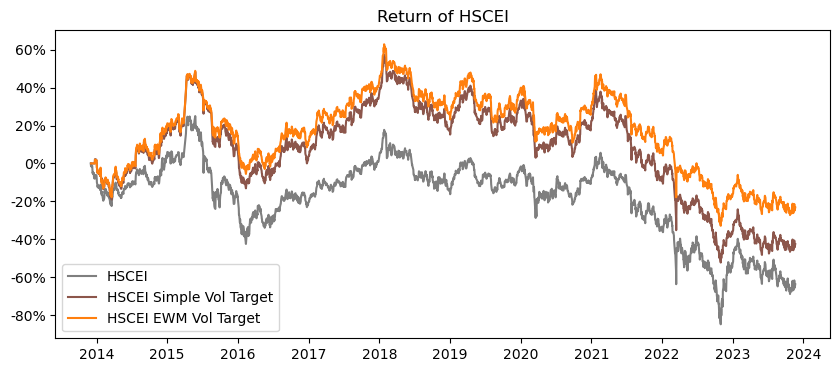

In [173]:
plt.figure(figsize = (10, 4))
plt.plot(df_hscei_idx['HSCEI_ret_acc'], label = 'HSCEI', color = 'tab:gray')
plt.plot(df_hscei_idx['HSCEI_lev_factor_ret_acc'], label = 'HSCEI Simple Vol Target', color = 'tab:brown')
plt.plot(df_hscei_idx['HSCEI_lev_factor_ret_ewm_acc'], label = 'HSCEI EWM Vol Target', color = 'tab:orange')
plt.title('Return of HSCEI')
plt.legend()

current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0%}'.format(x) for x in current_values])
plt.show()